#Model Selection and Cross-validation 



In this project I examine ["Forest Fires"](https://archive.ics.uci.edu/ml/datasets/Forest+Fires) dataset to predict the burned area of forest fires giving some features. I apply model selection and cross-validation methods for predictive assesment. 

In [1]:
import pandas as pd
import numpy as np
from numpy import *
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import make_scorer
from sklearn.base import BaseEstimator, TransformerMixin
from scipy.stats import chi2_contingency
np.set_printoptions(precision=3)
seed=0

In [2]:

df = pd.read_csv("forestfires.csv")

df.head(n=5)

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
0,7,5,mar,fri,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.0
1,7,4,oct,tue,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0.0
2,7,4,oct,sat,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0.0
3,8,6,mar,fri,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0.0
4,8,6,mar,sun,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0.0


In [3]:

df.info(verbose = True,memory_usage = True,show_counts = True)
null_count = df.isnull().sum().sum()
print('=' * 100)
print("The null count is: ", null_count)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517 entries, 0 to 516
Data columns (total 13 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   X       517 non-null    int64  
 1   Y       517 non-null    int64  
 2   month   517 non-null    object 
 3   day     517 non-null    object 
 4   FFMC    517 non-null    float64
 5   DMC     517 non-null    float64
 6   DC      517 non-null    float64
 7   ISI     517 non-null    float64
 8   temp    517 non-null    float64
 9   RH      517 non-null    int64  
 10  wind    517 non-null    float64
 11  rain    517 non-null    float64
 12  area    517 non-null    float64
dtypes: float64(8), int64(3), object(2)
memory usage: 52.6+ KB
The null count is:  0



1. There are 517 rows 
2. The data does not consist of null entries 
3. The categorical attributes are Month and Day attributes with type object



Using a threshold of statistical significance of 5%, I am checking the statistical significance for the labels of each categorical attribute. I am then grouping insignificant labels into two new statistically significant classes.

In [4]:

from scipy.stats import f_oneway 

print(df.month.value_counts())
anova_result_month = f_oneway(*[group["area"] for name, group in df.groupby("month")])

p_value_month = anova_result_month.pvalue

#print("Insignificant months with low counts: ", low_count_months)
print('=' * 100)
print("Statistical significance of 'month' with target var 'area':", p_value_month)
print('=' * 100)

month
aug    184
sep    172
mar     54
jul     32
feb     20
jun     17
oct     15
apr      9
dec      9
jan      2
may      2
nov      1
Name: count, dtype: int64
Statistical significance of 'month' with target var 'area': 0.9931307408492104


In [5]:

print(df.day.value_counts())

anova_result_day = f_oneway(*[group["area"] for name, group in df.groupby("day")])

p_value_day = anova_result_day.pvalue

#print("Insignificant months with low counts: ", low_count_months)
print('=' * 100)
print("Statistical significance of 'day' with target var 'area':", p_value_day)
print('=' * 100)

day
sun    95
fri    85
sat    84
mon    74
tue    64
thu    61
wed    54
Name: count, dtype: int64
Statistical significance of 'day' with target var 'area': 0.5246901872339957


In [6]:

#defining two new statistically significant labels for months 
warm_months = ['jun', 'jul', 'aug', 'sep']
cool_months = ['jan', 'feb', 'mar', 'apr', 'may', 'oct', 'nov', 'dec' ]

df['season'] = df['month'].apply(lambda x: 'Warm_month' if x in warm_months else 'Cold_month')

# Drop the original 'month' column
df.drop(columns=['month'], inplace=True)

#defining two new statistically significant labels for days 
weekday = ['mon', 'tue', 'wed', 'thu']
weekend = ['fri', 'sat', 'sun', ]

df['day_type'] = df['day'].apply(lambda x: 'weekday' if x in weekday else 'weekend')

# Drop the original 'month' column
df.drop(columns=['day'], inplace=True)


In [7]:
# Rechecking statistical significance

anova_result_month_adjusted = f_oneway(*[group["area"] for name, group in df.groupby("season")])
p_value_month_adjusted = anova_result_month_adjusted .pvalue

anova_result_day_adjusted = f_oneway(*[group["area"] for name, group in df.groupby("day_type")])
p_value_day_adjusted = anova_result_day_adjusted .pvalue


print("ANOVA p-value 'month' with adjusted labels:", p_value_month_adjusted)
print('=' * 100)
print("ANOVA p-value 'day' with adjusted labels:", p_value_day_adjusted)
print('=' * 100)
print(df['season'].value_counts())
print('=' * 100)
df['day_type'].value_counts()

ANOVA p-value 'month' with adjusted labels: 0.21483810114166912
ANOVA p-value 'day' with adjusted labels: 0.824860064629192
season
Warm_month    405
Cold_month    112
Name: count, dtype: int64


day_type
weekend    264
weekday    253
Name: count, dtype: int64

In [8]:
# Using "get_dummies" to perform one hot encoding to the categorical attributes to turn into numerical data

one_hot_encode= pd.get_dummies(df, columns=["season", 'day_type'], prefix_sep='_', dummy_na=False, sparse=False, drop_first= False, dtype=None)
one_hot_encode = one_hot_encode.astype(float)

one_hot_encode.head(n=5)

,X,Y,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area,season_Cold_month,season_Warm_month,day_type_weekday,day_type_weekend
0,7.0,5.0,86.2,26.2,94.3,5.1,8.2,51.0,6.7,0.0,0.0,1.0,0.0,0.0,1.0
1,7.0,4.0,90.6,35.4,669.1,6.7,18.0,33.0,0.9,0.0,0.0,1.0,0.0,1.0,0.0
2,7.0,4.0,90.6,43.7,686.9,6.7,14.6,33.0,1.3,0.0,0.0,1.0,0.0,0.0,1.0
3,8.0,6.0,91.7,33.3,77.5,9.0,8.3,97.0,4.0,0.2,0.0,1.0,0.0,0.0,1.0
4,8.0,6.0,89.3,51.3,102.2,9.6,11.4,99.0,1.8,0.0,0.0,1.0,0.0,0.0,1.0


In [9]:

one_hot_encode.columns

Index(['X', 'Y', 'FFMC', 'DMC', 'DC', 'ISI', 'temp', 'RH', 'wind', 'rain',
       'area', 'season_Cold_month', 'season_Warm_month', 'day_type_weekday',
       'day_type_weekend'],
      dtype='object')

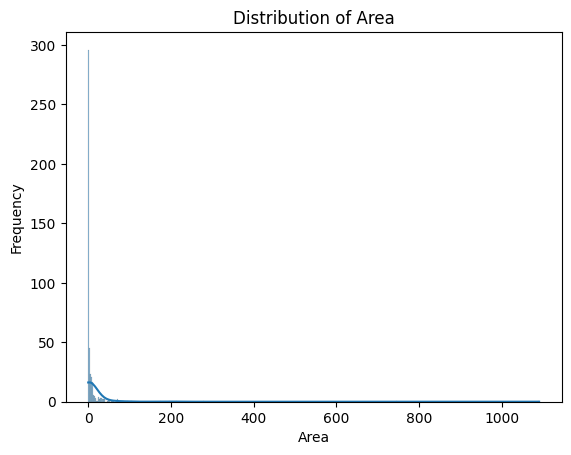

In [10]:
#Examining distribution of target variable 'Area'
sns.histplot(data=one_hot_encode, x='area', kde=True)
plt.xlabel('Area')
plt.ylabel('Frequency')
plt.title('Distribution of Area')
plt.show()

**Analysis of Graph:**
The graph is highly skewed to the left side with most of the data clustered between 0 and 1. This is an  indication that the distribution of area is dense between values of 0 and 1. Applying a log transform to this data would reduce the skewness of the graph. It compresses the values in the tail and pulls them closer to the mean, reducing the skewness of distribution. 

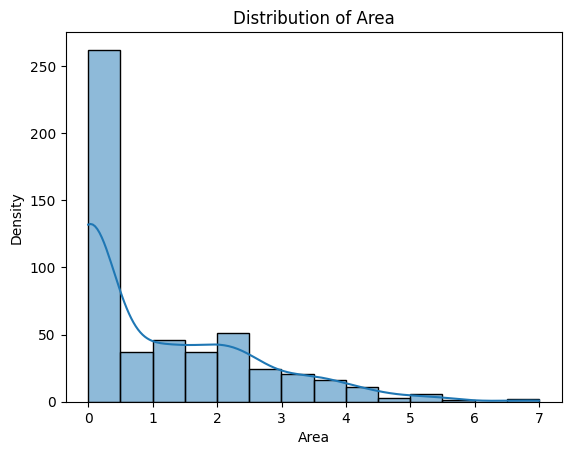

In [11]:


#adding 1 to account for 0 values and values between 0 -1 that return negative logs because area cannot be negative
one_hot_encode['area'] = np.log(one_hot_encode['area']+ 1)

sns.histplot(data=one_hot_encode, x='area', kde=True)
plt.xlabel('Area')
plt.ylabel('Density')
plt.title('Distribution of Area')
plt.show()

In [12]:
#Using Mean squared error as my score metric. Creating formula for y predicted and y 
def mse(y, ypr):
    res = ypr - y
    mse = np.sum(np.square(res))
    return mse 

In [13]:
#using all the features as predictors and the log transformed 'Area' as the target variable

X = one_hot_encode.drop('area', axis = 'columns')
y = one_hot_encode.area

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

print(X_train.shape, X_test.shape)

(413, 14) (104, 14)


In [14]:
#for model 1 performing linear regression on the data
m1 = Pipeline([
    ('linear_regression', LinearRegression())
])


In [15]:
#for model 2 adding quadratic terms for all features using Polynomial Features 
m2 = Pipeline([
    ('poly', PolynomialFeatures(degree=2, include_bias = False)),
    ('linear_regression', LinearRegression())
])

In [16]:
#Considering Temp and Rain as important features, adding a cubed term for temp and squared term for rain to increase importance.
#creating a custom transformer to speciy the above values

class KeyFeatures(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        X['temp2'] = X['temp'] ** 3
        X['rain2'] = X['rain'] ** 2
        return X

#for model 3 implementing the custom transformer for features Temp and Rain
m3 = Pipeline([
    ('keyFeatures', KeyFeatures()),
    ('linear_regression', LinearRegression())
])

In [17]:
# Applying 4-fold CV on all models to get mean and std of score  
sc = make_scorer(mse)

cvsc1= cross_val_score(m1, X_train, y_train, scoring=sc, cv=4)
cvsc2= cross_val_score(m2, X_train, y_train, scoring=sc, cv=4)
cvsc3= cross_val_score(m3, X_train, y_train, scoring=sc, cv=4)

print(f"M1 loss: %.4f +/- %.4f" % (cvsc1.mean(), cvsc1.std()))
print(f"M2 loss: %.4f +/- %.4f" % (cvsc2.mean(), cvsc2.std()))
print(f"M3 loss: %.4f +/- %.4f" % (cvsc3.mean(), cvsc3.std()))

M1 loss: 197.7463 +/- 10.5240
M2 loss: 382.5916 +/- 81.6609
M3 loss: 1569.0023 +/- 2367.1641


**Analysis of mean and std of all 3 Models:**
I would choose Model 2 over Model 1 because it demonstrates a reasonable balance between low mean loss (382.5916) and moderate standard deviation (81.6609). This suggests that on average, the model performs well in predicting the burned area, and the variability in its performance across different folds is relatively low compared to Model 1. This indicates a certain level of consistency in performance. Additionally, Model 2 has a significantly lower mean loss compared to Model 3.."

In [18]:
# estimating performance of model 2 using mse
m2 = m2.fit(X_train,y_train)
test_loss = mse(y_test,m2.predict(X_test))
print(f"MSE loss on test data: %.4f " %  test_loss)

MSE loss on test data: 286.2221 


 The central limit theorem (CLT) states that if you have a population with mean $\mu$ and standard deviation $\sigma$ and take sufficiently large random samples from the population with replacement, then the distribution of the sample means will be approximately normally distributed. This will hold true regardless of whether the source population is normal or skewed, provided the sample size is sufficiently large (usually greater than 30).

Computing a 95% confidence interval for the average test error using the Central Limit Theorem using the following formula:

$$ \bar{L_n} \pm 1.96 * \frac{\sigma_{l}}{\sqrt{n}}$$

Here $\bar{L_n}$ is the average test loss (i.e. for our test set), $\sigma_l$ is the standard deviation (of our test losses), and $n$ is the total number of test losses we compute.  

In [19]:
# Test loss here is a point estimate (statistic) for the generalization error
# Having >30 samples, we can use the formula above safely
# Here we compute confidence interval for generalization error (i.e.expected [average] test loss for this particular dataset)

z_value = 1.96  
std_loss= np.sqrt(test_loss) 
total_num_test_loss = len(y_test)


ci = z_value * (std_loss / np.sqrt(total_num_test_loss))
upper_bound = test_loss + ci
lower_bound = test_loss - ci

print('Confidence Interval is:', ci)
print('Upper Bound:', upper_bound)
print('Lower Bound:', lower_bound)

Confidence Interval is: 3.2515538647436864
Upper Bound: 289.47361333847306
Lower Bound: 282.97050560898566
